In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.distributions import Categorical
import torch.optim as optim
import ast
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
import torch.utils.data as Data
from sklearn.preprocessing import OneHotEncoder
import lightgbm as ltb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
import scikitplot as skplt
from sklearn import tree
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
public_test = pd.read_csv("sampleSubmission.csv")

In [3]:
X = pd.read_csv("my_train_X.csv", header=None)
y = pd.read_csv("my_train_y.csv", header=None)
test = pd.read_csv("my_test.csv", header=None)

In [4]:
X_copy = X.copy()
y_copy = y.copy()
test_copy = test.copy()

In [5]:
X_arr = X_copy.to_numpy()
y_arr = y_copy.to_numpy()
test_arr = test_copy.to_numpy()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, y_arr, test_size=0.25, random_state=42)

In [7]:
X_train_t = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.float32))
X_test_t = torch.from_numpy(X_test.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.float32))

In [8]:
X_train_t = X_train_t.to(device)
X_test_t = X_test_t.to(device)

In [9]:
model_loss = dict()

## lightGBM

C:\Users\crick\Apps\anacoda\envs\gpu1\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\crick\Apps\anacoda\envs\gpu1\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\crick\Apps\anacoda\envs\gpu1\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[10]	training's l2: 147066	valid_0's l2: 147668
[20]	training's l2: 144359	valid_0's l2: 144924
[30]	training's l2: 142911	valid_0's l2: 143459
[40]	training's l2: 142041	valid_0's l2: 142580
[50]	training's l2: 141450	valid_0's l2: 141985
[60]	training's l2: 141006	valid_0's l2: 141539
[70]	training's l2: 140660	valid_0's l2: 141209
[80]	training's l2: 140377	valid_0's l2: 140932
[90]	training's l2: 140101	valid_0's l2: 140680
[100]	training's l2: 139856	valid_0's l2: 140450


[139855.59295627635, 373.9727168608378, 140449.91008050076, 374.76647406151574]

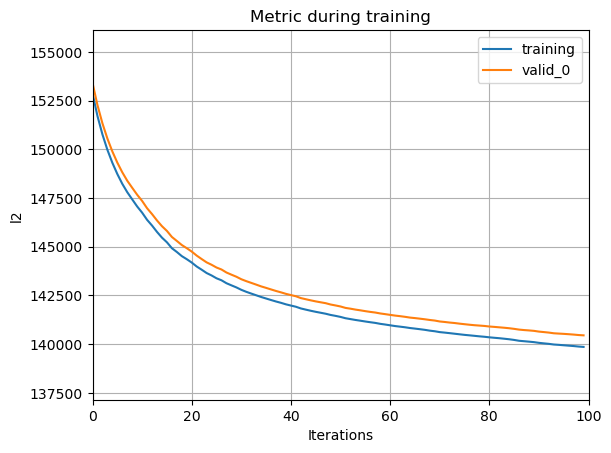

In [10]:
model_lg = ltb.LGBMRegressor()
model_lg.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=10)
ltb.plot_metric(model_lg)
y_train_pred_lg = model_lg.predict(X_train)
y_test_pred_lg = model_lg.predict(X_test)
train_loss_mse = mean_squared_error(y_train_pred_lg, y_train)
train_loss_rmse = np.sqrt(train_loss_mse)
test_loss_mse = mean_squared_error(y_test_pred_lg, y_test)
test_loss_rmse = np.sqrt(test_loss_mse)
model_loss['lg'] = [train_loss_mse, train_loss_rmse, test_loss_mse, test_loss_rmse]
model_loss['lg']

In [11]:
y_pred = model_lg.predict(test_arr)
public_test["TRAVEL_TIME"] = y_pred
public_test.to_csv("my_pred_lightGBM_noGrid.csv", index=None)

In [12]:
#y1 = model_lg.predict(X_train)
with open('model_lg.pkl','wb') as f:
    pickle.dump(model_lg,f)

## Linear Regression

In [13]:
reg = LinearRegression().fit(X_train, y_train)
y_pred_train_li = reg.predict(X_train)
y_pred_test_li = reg.predict(X_test)

train_mse_li = mean_squared_error(y_pred_train_li, y_train)
train_rmse_li = np.sqrt(train_mse_li)
test_mse_li = mean_squared_error(y_pred_test_li, y_test)
test_rmse_li = np.sqrt(test_mse_li)
model_loss['li'] = [train_mse_li, train_rmse_li, test_mse_li, test_rmse_li]
model_loss['li']

[142030.53450938614, 376.8693865378112, 142650.31012196973, 377.6907599107631]

In [15]:
y_pred_li = reg.predict(test_arr)
public_test["TRAVEL_TIME"] = y_pred_li
public_test.to_csv("my_pred_linear.csv", index=None)

In [16]:
#y2 = reg.predict(X_train)

In [17]:
with open('reg.pkl','wb') as f:
    pickle.dump(reg,f)

## Random Forest

In [18]:
# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=7)

rf.fit(X_train, y_train)

y_train_rf = rf.predict(X_train)
y_test_rf = rf.predict(X_test)

train_mse_rf = mean_squared_error(y_train_rf, y_train)
train_rmse_rf = np.sqrt(train_mse_rf)
test_mse_rf = mean_squared_error(y_test_rf, y_test)
test_rmse_rf = np.sqrt(test_mse_rf)

model_loss['rf'] = [train_mse_rf, train_rmse_rf, test_mse_rf, test_rmse_rf]
model_loss['rf']

C:\Users\crick\AppData\Local\Temp\ipykernel_37036\158994410.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


[191389.8288573169, 437.48123257725797, 192193.33849232137, 438.3986068549048]

In [19]:
y_pred_test_rf = rf.predict(test_arr)
public_test["TRAVEL_TIME"] = y_pred_test_rf
public_test.to_csv("my_pred_rf.csv", index=None)

In [20]:
#y3 = rf.predict(X_train)

In [21]:
with open('model_rf.pkl','wb') as f:
    pickle.dump(rf,f)

## Naive Bayes

In [10]:
y_train = [int(i) for i in y_train]
clf = linear_model.BayesianRidge()
clf.fit(X_train, y_train)

y_train_clf = clf.predict(X_train)
y_test_clf = clf.predict(X_test)
y_pred_test_clf = clf.predict(test_arr)

train_mse_clf = mean_squared_error(y_train_clf, y_train)
train_rmse_clf = np.sqrt(train_mse_clf)
test_mse_clf = mean_squared_error(y_test_clf, y_test)
test_rmse_clf = np.sqrt(test_mse_clf)

public_test["TRAVEL_TIME"] = y_pred_test_clf
public_test.to_csv("naive.csv", index=None)

model_loss['clf'] = [train_mse_clf, train_rmse_clf, test_mse_clf, test_rmse_clf]
model_loss['clf']

[142031.86947859958, 376.87115766346403, 142652.43747682933, 377.6935761656919]

In [11]:
#y4 = clf.predict(X_train)

In [18]:
with open('clf.pkl','wb') as f:
    pickle.dump(clf,f)

## MLP

In [19]:
train_data = Data.TensorDataset(X_train_t, y_train_t)
test_data = Data.TensorDataset(X_test_t, y_test_t)
train_loader = Data.DataLoader(dataset = train_data, batch_size = 30, 
                               shuffle = True, num_workers = 2)
test_loader = Data.DataLoader(dataset = test_data, batch_size = 30, 
                               shuffle = True, num_workers = 2)

In [20]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MLP, self).__init__() #Refers to the fact that this is a subclass of nn.Module and is inheriting all methods
        self.model = torch.nn.Sequential( #an ordered container of modules
            nn.Linear(input_dim, hidden_dim),
           ## nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 64),
           ## nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64,32),
           ## nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(32, 1)    
        )   
    def forward(self, x): #You never have to call model.forward(x)
        """
        the forward function is where computatioin gets done
        """
        out = self.model(x)    
        return out

In [21]:
input_size = 589
hidden_size = 128
model_mlp = MLP(input_size, hidden_size)
model_mlp.to(device)
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.00001)

In [22]:
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():  
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = (criterion(outputs, labels).item())*inputs.size(0)
            running_loss += loss
    return np.sqrt(running_loss / len(X_test))

In [23]:
rmses = []
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    model_mlp.train()
    for i,(b_x, b_y) in tqdm(enumerate(train_loader)):
        inputs = b_x.to(device)
        labels = b_y.to(device)
        optimizer.zero_grad()
        prediction = model_mlp(inputs)
        loss = criterion(prediction,labels)
        running_loss +=loss.item()*inputs.size(0) 
        
        loss.backward()
        optimizer.step()
    rmse = np.sqrt(running_loss/len(X_train))
    rmses.append(rmse)
    validation_loss = validate(model_mlp, test_loader, criterion)
    print(  'Epoch: {}/{}\t'.format(epoch+1, num_epochs),
            'Training Loss: {:.3f}\t'.format(rmse),
            'Validation Loss: {:.3f}\t'.format(validation_loss))

40932it [02:16, 300.80it/s]


Epoch: 1/1	 Training Loss: 632.954	 Validation Loss: 394.214	


In [24]:
X_test_t = X_test_t.to(device)
y_test_t = y_test_t.to(device)
model_mlp.eval()
prediction_mlp_validation = model_mlp(X_test_t)
loss_mlp_validation = criterion(prediction_mlp_validation, y_test_t)
# running_loss += loss.item()*inputs.size(0)
rmse = np.sqrt(loss_mlp_validation.item())
print('Validation Loss: {:.3f}\t'.format(rmse))

Validation Loss: 394.214	


In [25]:
test_X = torch.tensor(test_arr,dtype=torch.float32)
test_X = test_X.to(device)
model_mlp.eval()
prediction = model_mlp(test_X)
results = torch.squeeze(prediction, 1)

In [26]:
test_len = len(test_arr)
result_list = []
for i in range(test_len):
    result_list.append(results[i].item())
public_test["TRAVEL_TIME"] = result_list
public_test.to_csv("my_pred_mlp.csv", index=None)

In [27]:
model_mlp.eval()
X_pred = model_mlp(X_train_t)
rs = torch.squeeze(X_pred, 1)
rs_list = []
for i in range(len(X_train)):
    rs_list.append(rs[i].item())
mlp_train = np.array(rs_list)

model_mlp.eval()
X_pred = model_mlp(X_test_t)
rs = torch.squeeze(X_pred, 1)
rs_list = []
for i in range(len(X_test)):
    rs_list.append(rs[i].item())
mlp_valid = np.array(rs_list)

model_mlp.eval()
X_pred = model_mlp(test_X)
rs = torch.squeeze(X_pred, 1)
rs_list = []
for i in range(len(test_arr)):
    rs_list.append(rs[i].item())
mlp_test = np.array(rs_list)

In [28]:
np.savetxt('my_y5_mlp_train.csv', mlp_train, delimiter=',')
np.savetxt('my_y5_mlp_val.csv', mlp_valid, delimiter=',')
np.savetxt('my_y5_mlp_test.csv', mlp_test, delimiter=',')

In [1]:
Y_train = np.hstack((y_train_pred_lg.reshape((len(y_train_pred_lg), 1)), y_pred_train_li, 
                     y_train_rf.reshape((len(y_train_rf), 1)), y_train_clf.reshape((len(y_train_clf), 1)), 
                     np.array(mlp_train).reshape((len(mlp_train), 1))))
np.savetxt('my_Y_train.csv', Y_train, delimiter=',')

Y_valid = np.hstack((y_test_pred_lg.reshape((len(y_test_pred_lg), 1)), y_pred_test_li, 
                     y_test_rf.reshape((len(y_test_rf), 1)), y_test_clf.reshape((len(y_test_clf), 1)), 
                     np.array(mlp_valid).reshape((len(mlp_valid), 1))))
np.savetxt('my_Y_valid.csv', Y_valid, delimiter=',')

Y_test = np.hstack((y_pred.reshape((len(y_pred), 1)), y_pred_li, 
                    y_pred_test_rf.reshape((len(y_pred_test_rf), 1)), 
                    y_pred_test_clf.reshape((len(y_pred_test_clf), 1)), 
                    np.array(mlp_test).reshape((len(mlp_test), 1))))

np.savetxt('my_Y_test.csv', Y_test, delimiter=',')

NameError: name 'np' is not defined